卷积神经网络（Convolutional Neural Network，CNN）是一种专门用来处理具有类似网格结构数据的神经网络。例如时间序列数据（时间轴上有规律地采样形成的一维网格）和图像数据（二维的像素网格）。因此它被广泛用于图像识别、语音识别等各种场合，在图像识别的比赛中，基于深度学习的方法几乎都以 CNN 为基础。

# 1. 整体结构

之前介绍的神经网络中，相邻层的所有神经元之间都有连接，这称为全连接（Fully Connected）层或 Affine 层。全连接层后面跟着激活函数 ReLU 层（或者Sigmoid 层）。这里堆叠了4 层“Affine-ReLU”组合，然后第 5 层是全连接层，最后由 Softmax 层输出最终分类结果。

![img](images/chapter13/fully_connected.png)

CNN 中新增了Convolution 层和Pooling 层。典型 CNN 的层连接顺序是“Convolution - ReLU -（Pooling）”（Pooling 层有时会被省略）。

![img](images/chapter13/CNN.png)

# 2. 卷积层

## 2.1 全连接层存在的问题

输入数据的形状被全连接层“忽视”了。例如，向全连接层输入图像数据时，需要将 3 维图像数据（宽、高和通道数）拉平为 1 维数据。实际上，前面使用的 MNIST 数据集的例子中，输入图像就是 1 通道、高 28 像素、长 28 像素的（1, 28, 28）形状，但却被排成 1 列，以 784 个数据的形式输入到全连接层中。

图像的 3 维形状中含有重要的空间信息。例如，空间上邻近的像素为相似的值、RBG的各个通道之间分别有密切的关联性、相距较远的像素之间没有什么关联等，3 维形状中可能隐藏有值得提取的本质模式。但是，因为全连接层会忽视形状，将全部的输入数据作为相同的神经元（同一维度的神经元）处理，所以无法利用与形状相关的信息。

而卷积层可以保持数据形状不变。当输入数据是图像时，卷积层会以 3 维数据的形式接收输入数据，并同样以 3 维数据的形式输出至下一层。因此，在 CNN 中，可以正确理解图像等具有形状的数据。

CNN 中将卷积层的输出数据称为 **特征图**（**feature map**）。

## 2.2 卷积运算

对于输入数据，卷积运算以一定间隔滑动卷积核（或称为滤波器）的窗口并应用。将各个位置上卷积核的元素和输入的对应元素相乘，然后再求和（有时将这个计算称为乘积累加运算）。然后，将这个结果保存到输出的对应位置。将这个过程在所有位置都进行一遍，就可以得到卷积运算的输出。如果将一个二维数据定义为 $I$，二维卷积核定义为 $K$，则

$$ S(i,j) = (I *K)(i,j) = \sum_m \sum_n I(i+m,j+n)K(m,n)$$

假设用（height, width）表示数据和卷积核的形状，则下图中输入数据尺寸是(5, 5)，输出数据尺寸是(3, 3)，卷积核尺寸是(3, 3)，其数值为

$$ \Bigg(
   \begin{matrix}
   0 & 1 & 2 \\
   2 & 2 & 0 \\
   0 & 1 & 2
  \end{matrix} \Bigg)
$$

![img](images/chapter13/numerical_no_padding_no_strides.gif)

令 $i$ 为输入数据尺寸，$k$ 为卷积核尺寸，$o$ 为输出数据尺寸，则有关系：

$$ o = (i - k) + 1 $$

当卷积层数增加时，网络的空间维度最终会缩减到1×1，这种情况下增加的层就不可能进行有意义的卷积了。

在全连接的神经网络中，除了权重参数，还存在偏置。CNN 中，卷积核的参数就对应之前的权重。并且，CNN 中也存在偏置，偏置被加到应用了卷积核的所有元素上。

## 2.3 填充（padding）

在进行卷积层的处理之前，有时要向输入数据的周围填入固定的数据（通常为 0），这称为**填充**（padding），是卷积运算中经常会用到的处理。在下图中，对大小为 (4, 4) 的输入数据应用了幅度为 1 的填充。通过填充，大小为 (4, 4) 的输入数据变成了 (6, 6) 的形状。然后应用大小为 (3, 3) 的卷积核，生成了大小为 (4, 4) 的输出数据。

![img](images/chapter13/padding.png)

令 $p$ 为填充幅度，则有关系

$$ o = (i - k) + 2p + 1 $$

下图中的示例中，$i=5, k =4, p =2$，因此 $o=6$

![img](images/chapter13/arbitrary_padding_no_strides.gif)

### Same Padding

一类特殊的填充作为称之为 same padding，即使得输出数据尺寸等于输入数据尺寸。令卷积核尺寸 $k$ 为奇数（$k = 2n+1$），填充幅度 $p = \lfloor \frac{k}{2} \rfloor= n$，则有

$$ o = (i - 2n - 1)+2n+1 = i $$

下图中的示例中，$i=o=5, k = 3, p=1$

![img](images/chapter13/same_padding_no_strides.gif)

在这种情况下，只要硬件支持，网络就能包含任意多的卷积层，这是因为卷积运算不改变下一层的结构。然而，输入数据中靠近边界的部分相比于中间部分对于输出数据的影响更小。这可能会导致边界像素存在一定程度的欠表示。

### Full Padding

另一类特殊的填充作为称之为 full padding，即使卷积核与数据刚相交时开始做卷积，因此填充幅度 $p = k - 1$，

$$o = (i - k)+2(k-1)+1 = i+k-1$$

下图中的示例中，$i=5, k = 3, p=2$，因此 $o=6$
![img](images/chapter13/full_padding_no_strides.gif)

它进行了足够多的零填充，使得每个像素在每个方向上恰好被访问了 $k$ 次。

## 2.4 步幅

应用卷积核的位置间隔称为**步幅**（stride）。之前的例子中步幅都是 1，如果将步幅设为 2，则如下图所示，应用卷积核的窗口的间隔变为 2 个元素。

![img](images/chapter13/stride.png)

令 $i$ 为输入数据尺寸，$p$ 为填充幅度，$k$ 为卷积核尺寸，$s$ 为步幅大小，$o$ 为输出数据尺寸，则有：

$$ o = \lfloor \frac{i + 2p -k}{s} \rfloor + 1 $$

下图中的示例中，$i=5, k=3, s=2, p=1$，因此 $o=3$

![img](images/chapter13/padding_strides.gif)

## 2.5 三维数据的卷积运算

图像是三维数据，将其表示为多维数组时顺序为(channel, height, width)，例如通道数为 C、高度为 H、长度为 W 的数据的形状可以写成 $(C, H, W)$。在进行卷积运算时，除了高、宽方向之外还需要处理通道方向。通道方向上有多个特征图时，会按通道进行输入数据和卷积核的卷积运算，并将结果相加，从而得到输出。需要注意的是，输入数据和卷积核的通道数要为相同的值。

![img](images/chapter13/3D_conv_0.png)

这里以 3 通道的数据为例，输入数据尺寸是(3, 5, 5)，卷积核尺寸为(3, 3, 3)，填充幅度为0，步幅为1，则输出数据尺寸为(2, 2)。

![img](images/chapter13/3D_conv_1.png)

分步计算顺序如下所示：

![img](images/chapter13/3D_conv_2.png)

如果要在通道方向上也拥有多个卷积运算的输出，就需要用到多个卷积核。如下图所示，通过应用 $FN$ 个卷积核，输出特征图也生成了 $FN$ 个。如果将这 $FN$ 个特征图汇集在一起，就得到了形状为 $(FN, OH,OW)$ 的数据体。

![img](images/chapter13/multi_channel_conv.png)

进一步完善包含偏置加法运算的卷积运算，如下图所示。卷积核输出结果的形状是 $(FN, OH,OW)$ ，偏置的形状是 $(FN, 1, 1)$，这两个数据相加时，得益于 NumPy 的广播功能，按通道加上相同的偏置值。

![img](images/chapter13/multi_channel_conv_with_bias.png)

## 2.6 批处理

之前的全连接神经网络的实现对应了批处理，通过批处理能够实现高效化的运算和学习时对应 mini-batch 的 SGD 算法。卷积运算也同样支持批处理。为此，需要将在各层间传递的数据保存为四维数据，按(batch_num, channel, height, width)的顺序保存数据。

![img](images/chapter13/batch_conv.png)

## 2.7 卷积层的动机

卷积运算通过三个重要思想来帮助改进深度学习系统：**稀疏连接**（sparse connectivity）、**参数共享**（parameter sharing）、**等变表示**（equivariant representations）。

### 2.7.1 稀疏连接

传统的神经网络的全连接层使用矩阵乘法来建立输入与输出的连接关系。其中，参数矩阵中每一个单独的参数都描述了一个输入单元与一个输出单元间的交互。这意味着每一个输出单元与每一个输入单元都产生交互。然而，卷积网络具有稀疏连接（也叫作稀疏权重（sparse weights））的特征。这是通过使核的大小远小于输入数据大小来达到的。

例如，有 $m$ 个输入和 $n$ 个输出，那么全连接层的矩阵乘法需要 $m×n$ 个参数并且相应算法的时间复杂度为 $O(m×n)$。如果我们限制每一个输出拥有的连接数为 $k$，
那么稀疏的连接方法只需要 $k×n$ 个参数以及 $O(k×n)$ 的运行时间。在很多实际应用中，只需保持 $k$ 比 $m$ 小几个数量级，就能在机器学习的任务中取得好的表现。

![img](images/chapter13/sparse_connectivity.png)

在深度卷积网络中，处在网络深层的单元可能与绝大部分输入是间接交互的，这允许网络可以通过只描述稀疏连接的基石来高效地描述多个变量的复杂交互。下图中，灰色区域凸显了 $g3$ 神经元以及它的**感受野**（receptive field）。

![img](images/chapter13/receptive_field.png)

### 2.7.2 参数共享

参数共享是指在一个模型的多个函数中使用相同的参数。

在传统的神经网络中，当计算一层的输出时，权重矩阵的每一个元素只使用一次，当它乘以输入的一个元素后就再也不会用到了。

在卷积神经网络中，核的每一个元素都作用在输入的每一位置上。卷积运算中的参数共享保证了我们只需要学习一个参数集合，而不是对于每一位置都需要学习一个单独的参数集合。这虽然没有改变前向传播的运行时间（仍然是 $O(k×n)$），但它显著地把模型的存储需求降低至 $k$ 个参数，并且 $k$ 通常要比 $m$ 小很多个数量级。因此，卷积在存储需求和统计效率方面极大地优于稠密矩阵的乘法运算。

下图中的上半部分，单独的黑色箭头表示在全连接模型中对权重矩阵的中间元素的使用。这个模型没有使用参数共享，所以参数只使用了一次。而在卷积模型中因为参数共享，这个单独的参数被用于所有的输入位置。

![img](images/chapter13/parameter_sharing.png)

### 2.7.3 等变表示

参数共享的特殊形式使得神经网络层具有对**平移等变**（equivariance）的性质。如果一个函数满足输入改变，输出也以同样的方式改变这一性质，我们就说它是等变（equivariant）的。特别的是，如果函数 $f(x)$ 与 $g(x)$ 满足 $f(g(x))＝g(f(x))$，我们就说 $f(x)$ 对于变换 $g$ 具有等变性。对于卷积来说，如果令 $g$ 是输入的任意平移函数，那么卷积函数对于 $g$ 具有等变性。

例如，令 $I$ 表示图像在整数坐标上的亮度函数，$g$ 表示图像函数的变换函数使得 $I'＝g(I)$，其中图像函数 $I′$ 满足 $I′(x,y )＝I(x-1，y)$。这个函数把 $I$ 中的每个像素向右移动一个单位。如果我们先对 $I$ 进行这种变换然后进行卷积操作所得到的结果，与先对 $I$ 进行卷积然后再对输出使用平移函数 $g$ 得到的结果是一样的。

# 3. 池化层

池化函数使用某一位置的相邻输出的总体统计特征来代替网络在该位置的输出。例如，最大池化（Max Pooling）函数使用相邻矩形区域内的最大值。其它常用的池化函数包括相邻矩形区域内的平均值（Average Pooling）、L2范数以及基于距中心像素距离的加权平均函数。

一般来说，池化的窗口大小会和步幅设定成相同的值。下图是按步幅 2 进行2 × 2 的最大池化时的处理顺序。

![img](images/chapter13/max_pooling.png)

## 池化层的特征

- 池化只是从目标区域中取最大值（或者平均值），所以不存在要学习的参数。


- 经过池化运算，输入数据和输出数据的通道数不会发生变化。


- 对微小的位置变化具有鲁棒性
      不管采用什么样的池化函数，当输入做出少量平移时，经过池化函数后的大多数输出并不会发生改变。

# 4. 卷积层和池化层的实现

## 4.1 卷积层的实现

如果正常实现卷积运算，需要重复多层的 for 循环语句，但是存在使用 for 语句处理 NumPy 数组效率低下的缺点。这里，我们实现卷积运算不使用 for 语句，而是使用 im2col 这个便利的函数进行简单的实现。

**im2col**（image to column）函数将输入数据展开以适合卷积核（权重）。对三维的输入数据应用 im2col 后，数据被转换为二维矩阵，如下图所示。

![img](images/chapter13/im2col_3D.png)

使用 im2col 展开输入数据后，只需将卷积层的卷积核（权重）纵向展开为 1 列，并计算这 2 个矩阵的乘积即可。

![img](images/chapter13/trans_kernel.png)

进一步考虑 batch 大小，令输入数据的形状为 $(N, C, H, W)$，卷积核的形状为 $(FN, C, FH, FW)$，输出数据的形状为 $(N, FN, OH, OW)$。im2col 函数返回的二维数据形状为 $(N \times OH \times OW, C \times FH \times FW)$，卷积核被展开为形状为 $(C \times FH \times FW, FN)$ 的 2 维数组，然后进行矩阵乘法运算，最后要将二维输出数据转换为合适的形状。整个卷积运算流程如下图所示，

![img](images/chapter13/im2col_4D.png)

In [1]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : 由(数量, 通道, 高, 宽)的四维数组构成的输入数据
    filter_h : 卷积核的高
    filter_w : 卷积核的长
    stride : 步幅
    pad : 填充

    Returns
    -------
    col : 2维数组
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, out_h, out_w, filter_h, filter_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, :, :, y, x] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 2, 3, 1, 4, 5).reshape(N*out_h*out_w, -1)
    return col

在卷积核的应用区域重叠的情况下，使用 im2col 函数展开后，展开后的元素个数会多于原方块的元素个数。因此，使用 im2col 的实现存在比普通的实现消耗更多内存的缺点。

接下来使用 im2col 来实现卷积层，这里我们将卷积层实现为名为 Convolution 的类。

In [2]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = (H + 2*self.pad - FH)// self.stride + 1
        out_w = (W + 2*self.pad - FW)// self.stride + 1

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 展开卷积核
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        return out

forward() 函数的实现中，最后会将输出数据转换为合适的形状。

![img](images/chapter13/transpose.png)

以上就是卷积层的前向传播 forward 处理的实现，通过使用 im2col 进行数据展开后，可以像实现全连接层一样来实现。在进行卷积层的反向传播时，必须进行im2col 的逆处理。具体的实现见 demo_code/layers.py 文件中的代码。

## 4.2 池化层的实现

池化层的实现和卷积层相同，都使用 im2col 展开输入数据。不过，池化的情况下，在通道方向上是独立的，因此池化的应用区域按通道单独展开。

![img](images/chapter13/pooling.png)

像这样展开之后，最大池化层只需对展开的矩阵求各行的最大值，并转换为合适的形状即可。

![img](images/chapter13/pooling_implementation.png)

最大池化层的实现按下面 3 个阶段进行：

- 展开输入数据
- 求各行的最大值
- 转换为合适的输出大小

In [3]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        
        # 展开
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 最大值
        out = np.max(col, axis=1)
        
        # 转换
        out_h = (H - self.pool_h) // self.stride + 1
        out_w = (W - self.pool_w) // self.stride + 1
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        return out

池化层的 backward 处理可以参考 ReLU 层的实现中使用的 max 的反向传播，具体的实现见 demo_code/layers.py 文件中的代码。

# 5. CNN的实现

我们已经实现了卷积层和池化层，现在来组合这些层，搭建进行手写数字识别的卷积神经网络。网络的构成是“Convolution - ReLU - Pooling - Affine -
ReLU - Affine - Softmax”，我们将它实现为名为SimpleConvNet的类。

![img](images/chapter13/CNN_mnist.png)

SimpleConvNet 的初始化函数（\_\_init\_\_）参数如下：
- input_dim―输入数据的维度：（通道，高，长）
- conv_param―卷积层的超参数（字典）。字典的关键字如下：
      filter_num―卷积核的数量
      filter_size―卷积核的大小
      stride―步幅
      pad―填充
- hidden_size―隐藏层（全连接）的神经元数量
- output_size―输出层（全连接）的神经元数量
- weitght_int_std―初始化时权重的标准差

In [4]:
class SimpleConvNet:
    """简单的ConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

学习所需的参数是第 1 层的卷积层和剩余两个全连接层的权重和偏置，这些参数在初始化后保存在实例变量的 params 字典中。

然后，从最前面开始按顺序向有序字典（OrderedDict）的 layers 中添加层。只有最后的 SoftmaxWithLoss 层被添加到别的变量 last_layer 中。

像这样初始化后，进行推理的 predict 方法和求损失函数值的 loss 方法就可以像下面这样实现。

```python
def predict(self, x):
    for layer in self.layers.values():
        x = layer.forward(x)
    return x

def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)
```

接下来是基于误差反向传播法求梯度的代码实现。参数的梯度通过误差反向传播算法求出，因为已经在各层正确实现了正向传播和反向传播的功能，所以这里只需要以合适的顺序调用即可。最后，把各个权重参数的梯度保存到 grads 字典中。

```python
def gradient(self, x, t):
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
        dout = layer.backward(dout)

    # 设定
    grads = {}
    grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
    grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

    return grads
```

现在，使用这个 SimpleConvNet 网络在 MNIST 数据集进行训练。

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from demo_code.download import load_mnist
from demo_code.simple_convnet import SimpleConvNet
from demo_code.trainer import Trainer

max_epochs = 10

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

x_train = x_train[:, np.newaxis, :, :]
x_test = x_test[:, np.newaxis, :, :]

# 处理花费时间较长的情况下减少数据
x_train, t_train = x_train[:6000], t_train[:6000]
x_test, t_test = x_test[:1000], t_test[:1000]

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer.train()

Dataset loading completed
=== epoch:1, train acc:0.19, test acc:0.174 ===
=== epoch:2, train acc:0.84, test acc:0.827 ===
=== epoch:3, train acc:0.896, test acc:0.88 ===
=== epoch:4, train acc:0.927, test acc:0.887 ===
=== epoch:5, train acc:0.916, test acc:0.902 ===
=== epoch:6, train acc:0.938, test acc:0.926 ===
=== epoch:7, train acc:0.942, test acc:0.931 ===
=== epoch:8, train acc:0.954, test acc:0.944 ===
=== epoch:9, train acc:0.965, test acc:0.948 ===
=== epoch:10, train acc:0.969, test acc:0.954 ===
=============== Final Test Accuracy ===============
test acc:0.949


如果使用 MNIST 数据集训练 SimpleConvNet 网络，训练数据的识别率为 99.82%，测试数据的识别率为 98.96% 左右（每次学习的识别精度都会发生一些误差）。测试数据的识别率大约为 99%，就小型网络来说，这是一个非常高的识别率。

# 6. CNN的可视化

刚才我们对MNIST数据集进行了简单的CNN学习。当时，第 1 层的卷积层的权重的形状是(30, 1, 5, 5)，即 30 个大小为 5 × 5、通道为 1 的卷积核。这意味着卷积核可以可视化为单通道的 5 × 5 灰度图像。现在，我们将卷积层（第 1 层）的卷积核显示为图像。

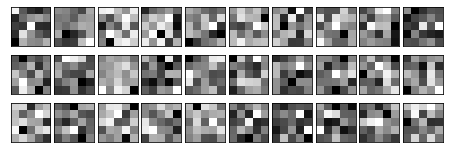

In [6]:
def filter_show(filters, nx=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.0, wspace=0.1)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 随机进行初始化的权重
filter_show(network.params['W1'])

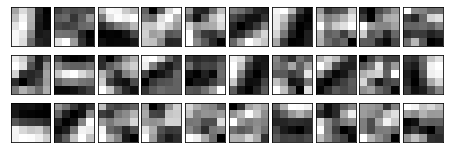

In [7]:
# 学习后的权重
network.load_params("demo_code/params.pkl")
filter_show(network.params['W1'])

从上图可以看出，学习前的滤波器是随机进行初始化的，没有规律可循。但学习后的滤波器变成了有规律的图像，有些滤波器对垂直方向上的边缘有响应，有些滤波器对水平方向上的边缘有响应。

上面的结果是针对第 1 层的卷积层得出的。第 1 层的卷积层中提取了边缘或斑块等“低级”信息，那么在堆叠了多层的 CNN 中，各层中又会提取什么样的信息呢？根据深度学习的可视化相关的研究，随着层次加深，提取的信息也越来越抽象。

下图展示了进行一般物体识别的 8 层 CNN。这个网络结构的名称是下一节要介绍的 AlexNet。AlexNet 网络结构堆叠了多层卷积层和池化层，最后经过全连接层输出结果。

![img](images/chapter13/CNN_visual.jpg)

随着卷积神经网络层次加深，提取的信息也愈加复杂、抽象。最开始的层对简单的边缘有响应，接下来的层对纹理有响应，再后面的层对更加复杂的物体部件有响应。也就是说，随着层次加深神经元从简单的形状向“高级”信息变化。